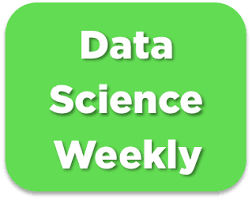

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [ ]:
!pip install plotly -q

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
data['country'].unique()

array(['China', 'UK', 'Germany', 'US'], dtype=object)

In [5]:
print(data['country'].value_counts())

US         160124
China       69122
UK          43641
Germany     11693
Name: country, dtype: int64


In [6]:
print(data['age'].value_counts())

28     12972
30     12956
29     12710
27     12668
26     12525
31     12327
25     12157
32     12111
24     11647
33     11392
23     11097
34     10911
22     10471
35     10352
21      9870
36      9668
20      9131
37      8773
19      8452
38      8067
18      7662
39      7343
17      6825
40      6451
41      5783
42      5029
43      4423
44      3808
45      3249
46      2693
47      2255
48      1898
49      1467
50      1213
51       990
52       835
53       571
54       459
55       352
56       251
57       211
58       147
59       115
60        86
61        63
62        50
63        29
64        26
65        14
66         9
67         5
68         2
70         2
73         1
79         1
77         1
111        1
72         1
69         1
123        1
Name: age, dtype: int64


In [7]:
print(data['new_user'].value_counts())

1    195066
0     89514
Name: new_user, dtype: int64


In [8]:
print(data['total_pages_visited'].value_counts())

2     39546
3     39465
4     36918
1     36637
5     32654
6     27198
7     21112
8     15768
9     10972
10     7312
11     4846
12     3233
13     2191
14     1611
15     1196
16      997
17      767
18      653
19      506
20      372
21      266
22      162
23       99
24       40
25       34
26       15
27        7
29        2
28        1
Name: total_pages_visited, dtype: int64


In [9]:
data['source'].unique()

array(['Direct', 'Ads', 'Seo'], dtype=object)

In [10]:
print(data.sort_values(by=['total_pages_visited']))

        country  age  new_user  source  total_pages_visited  converted
50727     China   24         0     Seo                    1          0
73476     China   27         1     Ads                    1          0
32950        UK   17         1     Ads                    1          0
32953        US   23         1  Direct                    1          0
151747       US   38         1  Direct                    1          0
...         ...  ...       ...     ...                  ...        ...
84783   Germany   22         1     Seo                   27          1
88265        US   24         0     Seo                   27          1
223544       US   17         1  Direct                   28          1
211172       US   31         0     Ads                   29          1
232167       US   33         0  Direct                   29          1

[284580 rows x 6 columns]


In [11]:
converted_data = data.loc[data['converted'] == 1]
converted_data

,country,age,new_user,source,total_pages_visited,converted
2,Germany,20,0,Seo,14,1
12,Germany,27,1,Ads,14,1
42,UK,27,0,Seo,16,1
127,US,32,1,Seo,19,1
200,US,41,0,Seo,20,1
...,...,...,...,...,...,...
284434,US,22,0,Direct,23,1
284464,US,23,0,Seo,15,1
284486,US,32,0,Seo,21,1
284563,Germany,40,1,Seo,13,1


## ≈ 3.23% of the users become subscribers

In [12]:
converted_per_country = converted_data.groupby(['country']).size().reset_index(name='Count')
converted_per_country

,country,Count
0,China,89
1,Germany,730
2,UK,2291
3,US,6070


In [13]:
converted_china = converted_data.groupby(['country', 'total_pages_visited']).size().reset_index(name='Count')
converted_china = converted_china.loc[converted_china['country'] == 'China']
converted_china

,country,total_pages_visited,Count
0,China,6,1
1,China,7,1
2,China,8,4
3,China,9,3
4,China,10,1
5,China,11,6
6,China,12,9
7,China,13,15
8,China,14,14
9,China,15,9


In [14]:
converted_germany = converted_data.groupby(['country', 'total_pages_visited']).size().reset_index(name='Count')
converted_germany = converted_germany.loc[converted_germany['country'] == 'Germany']
converted_germany

,country,total_pages_visited,Count
17,Germany,2,1
18,Germany,3,2
19,Germany,4,3
20,Germany,5,1
21,Germany,6,9
22,Germany,7,9
23,Germany,8,22
24,Germany,9,29
25,Germany,10,39
26,Germany,11,49


In [15]:
converted_uk = converted_data.groupby(['country', 'total_pages_visited']).size().reset_index(name='Count')
converted_uk = converted_uk.loc[converted_uk['country'] == 'UK']
converted_uk

,country,total_pages_visited,Count
43,UK,2,3
44,UK,3,3
45,UK,4,6
46,UK,5,15
47,UK,6,16
48,UK,7,30
49,UK,8,61
50,UK,9,96
51,UK,10,109
52,UK,11,156


In [16]:
converted_us = converted_data.groupby(['country', 'total_pages_visited']).size().reset_index(name='Count')
converted_us = converted_us.loc[converted_us['country'] == 'US']
converted_us

,country,total_pages_visited,Count
69,US,2,5
70,US,3,6
71,US,4,20
72,US,5,35
73,US,6,68
74,US,7,99
75,US,8,154
76,US,9,236
77,US,10,293
78,US,11,374


In [17]:
converted_per_age = converted_data.groupby(['age']).size().reset_index(name='Count')
converted_per_age

,age,Count
0,17,495
1,18,492
2,19,491
3,20,525
4,21,540
5,22,556
6,23,545
7,24,521
8,25,459
9,26,500


In [18]:
converted_per_visited_page = converted_data.groupby(['total_pages_visited']).size().reset_index(name='Count')
converted_per_visited_page

,total_pages_visited,Count
0,2,9
1,3,11
2,4,29
3,5,51
4,6,94
5,7,139
6,8,241
7,9,364
8,10,442
9,11,585


## We can see, more the users visit the pages, more the conversion probabilities increase. 

## We can note that after 14 pages visited, the number of conversions starts to decrease ! 

## Closer we get to 20, more the number drops. Once exceeded and approaching 30, the decrease is very strong

# Explore dataset

In [19]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [20]:
from sklearn.preprocessing import OrdinalEncoder

#ord_enc = OrdinalEncoder()
#data["country_code"] = ord_enc.fit_transform(data[["country"]]) # Countries can't be convert into string. We have to encode them
#data["source_code"] = ord_enc.fit_transform(data[["source"]]) # The same for the sources

#data[["country", "country_code"]].head()
#data = data.drop(columns=['country', 'source'])
#data

In [21]:
target_variable = 'converted'

In [22]:
X = data.loc[:,[c for c in data.columns if c!=target_variable]] # All columns are kept, except the target
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [23]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [24]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['China' 23 0 'Direct' 4]
 ['US' 25 1 'Direct' 8]
 ['US' 32 1 'Seo' 2]
 ['US' 37 1 'Seo' 3]
 ['UK' 24 1 'Direct' 4]]
[['US' 20 1 'Ads' 7]
 ['US' 31 1 'Seo' 5]]

[0, 0, 0, 0, 0]
[0, 0]


## Training pipeline

In [25]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [26]:
# Create pipeline for categorical features
numeric_features = [1,4]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values in Age will be replaced by columns’ mean
    ('scaler', StandardScaler())])

# Create pipeline for categorical features
categorical_features = [0, 2, 3]
categorical_transformer = Pipeline(
    steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first'))]) # first column will be dropped to avoid creating correlations between features

# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),    
        ('num', numeric_transformer, numeric_features)
        ]
    )

Encoding categorical features and standardizing numerical features...


In [27]:
# Preprocessings on train set

X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)

In [28]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


## Test pipeline

In [29]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train) 

# Predictions on training set
Y_train_pred = classifier.predict(X_train)
# Predictions on test set
Y_test_pred = classifier.predict(X_test)

## Performance assessment

In [30]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7639889569725944
f1-score on test set :  0.7562828755113967


In [31]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[246944    955]
 [  2550   5673]]

Confusion matrix on test set : 
[[27394   107]
 [  310   647]]



Train set
La matrice de confusion montre que le modèle semble assez robuste sur le train !


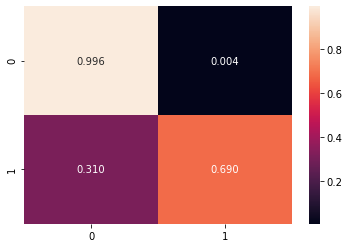

In [32]:
print('Train set')
cm = confusion_matrix(Y_train, Y_train_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.3f');
print('La matrice de confusion montre que le modèle semble assez robuste sur le train !')

Test set
La matrice de confusion montre que le modèle semble assez robuste sur le test !


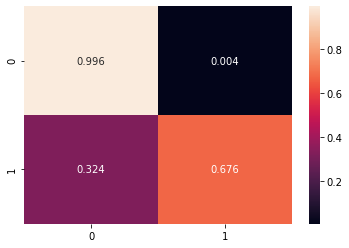

In [33]:
print('Test set')
cm = confusion_matrix(Y_test, Y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt='.3f');
print('La matrice de confusion montre que le modèle semble assez robuste sur le test !')

# Decision tree classifier

In [34]:
# Perform grid search
print("Grid search...")
classifier = DecisionTreeClassifier()
classifier.fit(X_train, Y_train)

Grid search...


DecisionTreeClassifier()

In [35]:
# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best validation accuracy :  0.9852335996126845


## Performances

In [36]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [37]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [38]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9861238003763831
accuracy on test set :  0.9852414083913135

f1-score on training set :  0.7628453223008141
f1-score on test set :  0.7583429228998849



Decision tree's test set


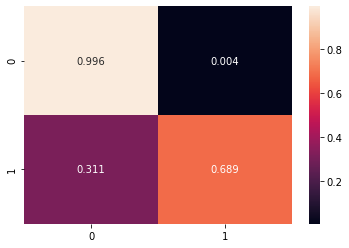

In [39]:
print("Decision tree's test set")
cm_test = confusion_matrix(Y_test, Y_test_pred, normalize = "true")
sns.heatmap(cm_test, annot=True, fmt='.3f');

# Random forest

In [40]:
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()
classifier.fit(X_train, Y_train)

Grid search...


RandomForestClassifier()

In [42]:
# Grid of values to be tested
params = {
    'max_depth': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [25, 50, 100]
}

gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3, verbose=2) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=25 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=25, total=   1.5s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=25, total=   1.7s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=25 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=25, total=   1.4s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   2.9s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   3.1s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, total=   2.8s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   5.7s
[CV] max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=

[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 15.3min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5, 10], 'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [25, 50, 100]},
             verbose=2)

In [43]:
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 50}
Best validation accuracy :  0.9859481028572321


## Performances

In [44]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [45]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [46]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9871077064836289
accuracy on test set :  0.9852765478951437

f1-score on training set :  0.7771629099743554
f1-score on test set :  0.7571014492753623



Random forest test set


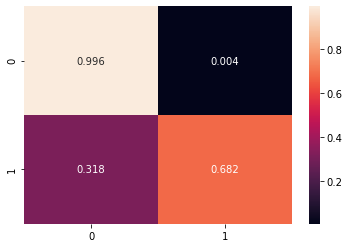

In [47]:
print("Random forest test set")
cm_random_forest = confusion_matrix(Y_test, Y_test_pred, normalize = "true")
sns.heatmap(cm_random_forest, annot=True, fmt='.3f');

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [48]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

RandomForestClassifier()

In [57]:
data_without_labels

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14


In [53]:
# Read data without labels
data_without_labels = pd.read_csv('data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['country',	'age',	'new_user',	'source', 'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16 'UK' 28 0 'Seo']
 [5 'UK' 22 1 'Direct']
 [1 'China' 32 1 'Seo']
 [6 'US' 32 1 'Ads']
 [3 'China' 25 0 'Seo']]


In [54]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...


ValueError: Found unknown categories [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26] in column 0 during transform

In [ ]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**